# Masalah

Dalam pengawasan reputasi online, perusahaan perlu dapat mengidentifikasi apakah ulasan atau komentar pelanggan tentang produk atau layanan mereka memiliki respon emosi seperti apa. Hal ini penting untuk mengetahui apakah pelanggan puas atau tidak dengan pengalaman mereka, sehingga perusahaan dapat merespons dengan cepat terhadap masalah yang muncul atau memperbaiki aspek-aspek yang tidak memuaskan dan mampu memberikan respon terhadap emosi pelanggan dengan sesuai.

Model: BERTweet https://huggingface.co/vinai/bertweet-base

Sumber dataset: https://www.kaggle.com/datasets/praveengovi/emotions-dataset-for-nlp

In [460]:
CUDA_LAUNCH_BLOCKING="1"

In [461]:
!pip install transformers
!pip install datasets
!pip3 install emoji==0.6.0

In [462]:
from datasets import load_dataset
import transformers
from transformers import AutoModel, AutoTokenizer, pipeline
import torch
import re
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, recall_score, f1_score, accuracy_score, average_precision_score
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
%matplotlib inline

nltk.download("stopwords")
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer= WordNetLemmatizer()

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU is not available


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cleve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cleve\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Import Hugging Face

In [463]:
bertweet = AutoModel.from_pretrained("vinai/bertweet-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization = True, use_fast=False)

c:\Users\cleve\.conda\envs\deeplearning\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


# Data Preprocessing

## Import Data

### Data Train

In [464]:
import pandas as pd

data_train = pd.read_csv('train.txt', names=['body', 'target'], sep=';')

display(data_train)

,body,target
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
...,...,...
15995,i just had a very brief time in the beanbag an...,sadness
15996,i am now turning and i feel pathetic that i am...,sadness
15997,i feel strong and good overall,joy
15998,i feel like this was such a rude comment and i...,anger


### Data Test

In [465]:
data_test = pd.read_csv('test.txt', names=['body', 'target'], sep=';')

display(data_test)

,body,target
0,im feeling rather rotten so im not very ambiti...,sadness
1,im updating my blog because i feel shitty,sadness
2,i never make her separate from me because i do...,sadness
3,i left with my bouquet of red and yellow tulip...,joy
4,i was feeling a little vain when i did this one,sadness
...,...,...
1995,i just keep feeling like someone is being unki...,anger
1996,im feeling a little cranky negative after this...,anger
1997,i feel that i am useful to my people and that ...,joy
1998,im feeling more comfortable with derby i feel ...,joy


### Data Val

In [466]:
data_val = pd.read_csv('val.txt', names=['body', 'target'], sep=';')

display(data_val)

,body,target
0,im feeling quite sad and sorry for myself but ...,sadness
1,i feel like i am still looking at a blank canv...,sadness
2,i feel like a faithful servant,love
3,i am just feeling cranky and blue,anger
4,i can have for a treat or if i am feeling festive,joy
...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness
1996,i constantly worry about their fight against n...,joy
1997,i feel its important to share this info for th...,joy
1998,i truly feel that if you are passionate enough...,joy


## Assessing

In [467]:
df_train = data_train
df_val = data_val
df_test = data_test

### Data Train

In [468]:
#check if the data is balanced or not
df_train.target.value_counts()

target
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [469]:
#check if the data is balanced or not
df_train.target.value_counts() / df_train.shape[0] *100

target
joy         33.51250
sadness     29.16250
anger       13.49375
fear        12.10625
love         8.15000
surprise     3.57500
Name: count, dtype: float64

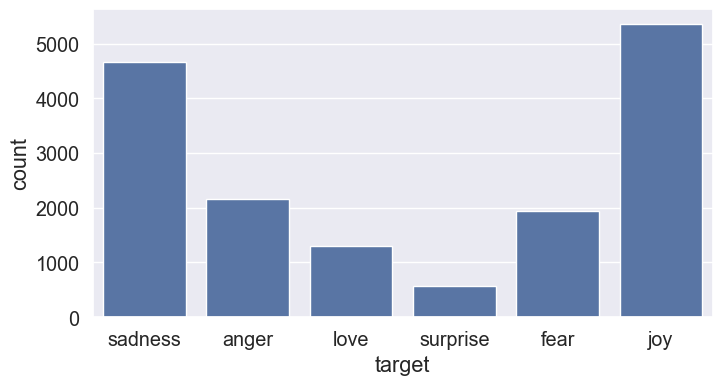

In [470]:
plt.figure(figsize=(8,4))
sns.countplot(x='target', data=df_train);

In [471]:
#print the number of null values in each column
df_train.isnull().sum()

body      0
target    0
dtype: int64

Data tidak berisi nilai null

In [472]:
#print the number of duplicated values
df_train.duplicated().sum()

1

Hanya ada satu baris yang terduplikasi tetapi kita perlu memeriksa juga apakah ada baris yang memiliki teks yang sama tetapi emosinya berbeda

In [473]:
#removing duplicated values
index = df_train[df_train.duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [474]:
#print the rows which are duplicated (duplicated in the text but with different emotions)
df_train[df_train['body'].duplicated() == True]

,body,target
5067,i feel on the verge of tears from weariness i ...,joy
6133,i still feel a craving for sweet food,love
6563,i tend to stop breathing when i m feeling stre...,anger
7623,i was intensely conscious of how much cash i h...,sadness
7685,im still not sure why reilly feels the need to...,surprise
8246,i am not amazing or great at photography but i...,love
9596,ive also made it with both sugar measurements ...,joy
9687,i had to choose the sleek and smoother feel of...,joy
9769,i often find myself feeling assaulted by a mul...,sadness
9786,i feel im being generous with that statement,joy


In [475]:
df_train[df_train['body'] == df_train.iloc[14313]['body']]


,body,target
13653,i could feel myself hit this strange foggy wall,fear
14313,i could feel myself hit this strange foggy wall,surprise


Bisa terlihat bahwa data memiliki text yang sama namun target yang berbeda. Kita perlu memperbaikinya.

In [476]:
#removing duplicated text
index = df_train[df_train['body'].duplicated() == True].index
df_train.drop(index, axis = 0, inplace = True)
df_train.reset_index(inplace=True, drop = True)

In [477]:
#Count the number of stopwords in the data
temp =df_train.copy()
stop_words = set(stopwords.words("english"))
temp['stop_words'] = temp['body'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()

stop_words
5     1416
7     1405
6     1392
4     1341
8     1319
3     1263
9     1177
10    1048
2      922
11     889
12     752
13     644
14     493
1      450
15     376
16     265
17     238
18     164
19     113
20      90
0       79
21      60
22      33
23      19
24       7
25       6
26       6
28       1
29       1
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

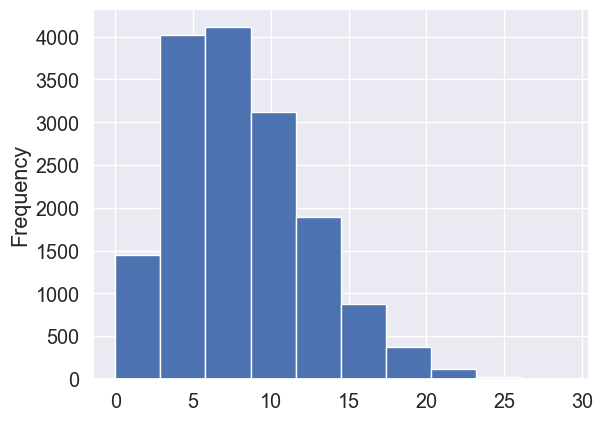

In [478]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

### Data Test

In [479]:
#check if the data is balanced or not
df_test.target.value_counts()

target
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

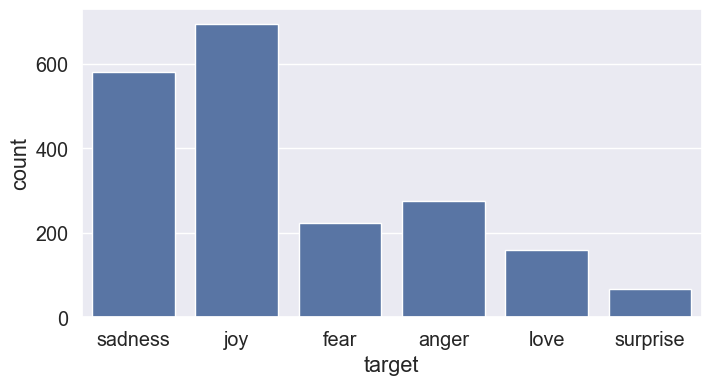

In [480]:
plt.figure(figsize=(8,4))
sns.countplot(x='target', data=df_test);

In [481]:
#print the number of null values in each column
df_test.isnull().sum()

body      0
target    0
dtype: int64

In [482]:
#print the rows which are duplicated
df_test[df_test['body'].duplicated() == True]

,body,target


<Axes: ylabel='Frequency'>

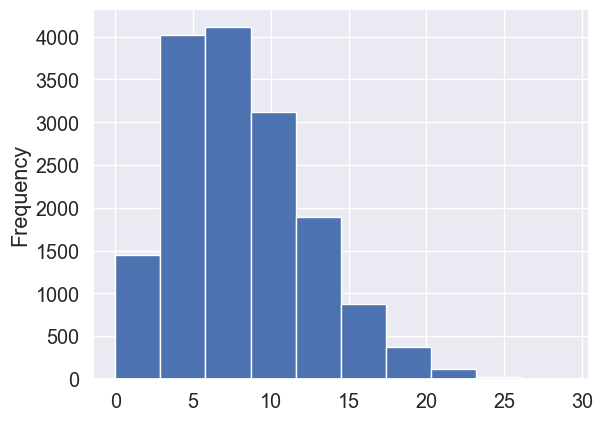

In [483]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist')

Tidak ada data test yang terduplikasi

In [484]:
#Count the number of stopwords in the data
temp =df_test.copy()
temp['stop_words'] = temp['body'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()


stop_words
7     184
6     179
3     175
5     175
4     163
9     163
8     139
10    123
2     118
11    115
12     84
13     71
15     61
14     58
1      42
16     40
17     31
18     22
20     17
19     11
21     10
0       8
23      7
24      2
22      2
Name: count, dtype: int64

### Data Validation

In [485]:
#check if the data is balanced or not
df_val.target.value_counts()

target
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: count, dtype: int64

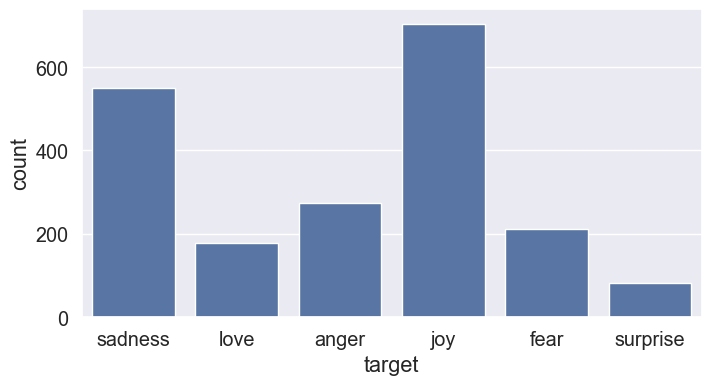

In [486]:
plt.figure(figsize=(8,4))
sns.countplot(x='target', data=df_val);

In [487]:
#print the number of null values in each column
df_val.isnull().sum()

body      0
target    0
dtype: int64

In [488]:
#print the number of duplicated values
df_val.duplicated().sum()

0

In [489]:
#print the rows which are duplicated
df_val[df_val['body'].duplicated() == True]

,body,target
603,i have had several new members tell me how com...,joy
1993,i feel so tortured by it,anger


In [490]:
df_val[df_val['body'] == df_val.iloc[1993]['body']]


,body,target
774,i feel so tortured by it,fear
1993,i feel so tortured by it,anger


In [491]:
#removing duplicated text
index = df_val[df_val['body'].duplicated() == True].index
df_val.drop(index, axis = 0, inplace = True)
df_val.reset_index(inplace=True, drop = True)

In [492]:
#Count the number of stopwords in the data
temp =df_val.copy()
temp['stop_words'] = temp['body'].apply(lambda x: len(set(x.split()) & set(stop_words)))
temp.stop_words.value_counts()[:10]


stop_words
7     190
5     175
8     173
6     160
3     160
10    150
9     146
4     145
2     133
11    103
Name: count, dtype: int64

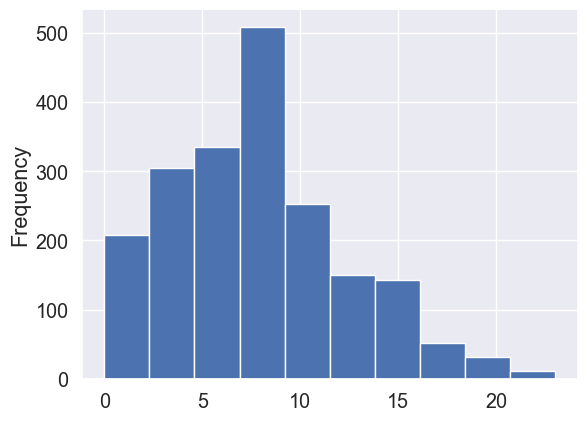

In [493]:
sns.set(font_scale=1.3)
temp['stop_words'].plot(kind= 'hist');

## Cleaning

In [494]:
def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]

    return " " .join(text)

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):

    text = text.split()

    text=[y.lower() for y in text]

    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )

    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan

def normalize_text(df):
    df.body=df.body.apply(lambda text : lower_case(text))
    df.body=df.body.apply(lambda text : remove_stop_words(text))
    df.body=df.body.apply(lambda text : Removing_numbers(text))
    df.body=df.body.apply(lambda text : Removing_punctuations(text))
    df.body=df.body.apply(lambda text : Removing_urls(text))
    df.body=df.body.apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence



In [495]:
normalized_sentence("My Name is Mohamed. @Tweets,  plays 2022  Egypt_")

'name mohamed tweet play egypt'

In [496]:
df_train= normalize_text(df_train)
df_val= normalize_text(df_val)
df_test= normalize_text(df_test)

## Encoding

In [497]:
# Find unique values in the 'sentiment' column
unique_sentiments = df_train['target'].unique()

# Display the unique sentiments
print(unique_sentiments)

['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [498]:
sentiment_mapping = {
    'sadness': 0,
    'joy': 1,
    'fear': 2,
    'anger': 3,
    'love': 4,
    'surprise': 5
}

In [499]:
df_train['target'] = df_train['target'].map(sentiment_mapping)
df_test['target'] = df_test['target'].map(sentiment_mapping)
df_val['target'] = df_val['target'].map(sentiment_mapping)

In [500]:
df_train.head()

,body,target
0,didnt feel humiliated,0
1,go feeling hopeless damned hopeful around some...,0
2,im grabbing minute post feel greedy wrong,3
3,ever feeling nostalgic fireplace know still pr...,4
4,feeling grouchy,3


In [501]:
df_test.head()

,body,target
0,im feeling rather rotten im ambitious right,0
1,im updating blog feel shitty,0
2,never make separate ever want feel like ashamed,0
3,left bouquet red yellow tulip arm feeling slig...,1
4,feeling little vain one,0


In [502]:
df_val.head()

,body,target
0,im feeling quite sad sorry ill snap soon,0
1,feel like still looking blank canvas blank pie...,0
2,feel like faithful servant,4
3,feeling cranky blue,3
4,treat feeling festive,1


# Evaluate Model (BERTweet)

In [503]:
PRE_TRAINED_MODEL_NAME = "vinai/bertweet-base"

In [504]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = bertweet.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
    )
    output = pooled_output
    return self.out(output)

In [505]:
n_classes = 6
class_names = ['sadness','anger','love','surprise','fear','joy']

In [506]:
model = SentimentClassifier(n_classes)
model = model.to(device)

c:\Users\cleve\.conda\envs\deeplearning\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [507]:
model.load_state_dict(torch.load('model/bertweet_best_model_state.bin', map_location=torch.device('cpu')))

<All keys matched successfully>

In [508]:
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer

def predict_sentence(model, tokenizer, sentence, device):
    model = model.eval()

    # Tokenize the input sentence
    encoding = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        probs = F.softmax(outputs, dim=1)

    prediction = preds.item()
    prediction_probs = probs.squeeze().tolist()

    index_to_sentiment = {v: k for k, v in sentiment_mapping.items()}
    predicted_sentiment = index_to_sentiment[prediction]

    return sentence, predicted_sentiment, prediction_probs

In [529]:
sentence = "The unexpected fireworks lit up the night sky, leaving everyone in amazed."
normalized_sentence(sentence)
tweets_content, predicted_sentiment, prediction_probs = predict_sentence(model, tokenizer, sentence, device)
proba = np.max(prediction_probs)
# Print results
print(f"Sentence: {tweets_content}")
print(f"Prediction: {predicted_sentiment} = {proba:.4f}")
print(f"Prediction Probabilities: {prediction_probs}")

Sentence: The unexpected fireworks lit up the night sky, leaving everyone in amazed.
Prediction: surprise = 0.9547
Prediction Probabilities: [0.0023976669181138277, 0.004088199231773615, 0.020863356068730354, 0.014336942695081234, 0.00360847357660532, 0.9547052979469299]


# Training Model (LSTM)

Word embedding using glove and sequence model

In [510]:
# Modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split,KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.svm import SVC

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

## Text Preprocessing

In [511]:
#Preprocess text
X_train = df_train['body']
y_train = df_train['target']

X_test = df_test['body']
y_test = df_test['target']

X_val = df_val['body']
y_val = df_val['target']

0 = Sadness<br>
1 = Joy<br>
2 = Fear<br>
3 = Anger<br>
4 = Love<br>
5 = Surprise

In [512]:
# Encode labels
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
y_val = le.transform(y_val)

In [513]:
#print the labels after encoding
print(set(y_train))

{0, 1, 2, 3, 4, 5}


In [514]:
#Convert the class vector (integers) to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [515]:
print(y_train)

[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]


## Tokenizing

In [516]:
# Tokenize words
lstm_tokenizer = Tokenizer(oov_token='UNK')
lstm_tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [517]:
#converting a single sentence to list of indexes
lstm_tokenizer.texts_to_sequences(X_train[0].split())

[[53], [2], [531]]

In [518]:
#convert the list of indexes into a matrix of ones and zeros (BOW)
lstm_tokenizer.texts_to_matrix(X_train[0].split())

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [519]:
sequences_train = lstm_tokenizer.texts_to_sequences(X_train)
sequences_test = lstm_tokenizer.texts_to_sequences(X_test)
sequences_val = lstm_tokenizer.texts_to_sequences(X_val)

## Padding

The vectors we obtain are generally not of equal lengths

For that, we might need to pad the sequences to max len.

In [520]:
df_test.shape

(2000, 2)

In [521]:
maxlen = max([len(t) for t in df_train['body']])
maxlen

229

In [523]:
X_train = pad_sequences(sequences_train, maxlen=maxlen, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=maxlen, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=maxlen, truncating='pre')

vocabSize = len(lstm_tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 14325


In [524]:
#before
sequences_train[0]

[53, 2, 531]

In [525]:
#after
X_train[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

## Evaluate Model

In [526]:
from keras.models import load_model
lstm_model = load_model('model/lstm_emotion_recognition_eng.h5')

In [527]:
sentence = "The unexpected fireworks lit up the night sky, leaving everyone in amazed."
print(sentence)

# Normalize the sentence
sentence = normalized_sentence(sentence)

# Tokenize the sentence
sentence = lstm_tokenizer.texts_to_sequences([sentence])

# Pad the sequence
sentence = pad_sequences(sentence, maxlen=229, truncating='pre')

# Predict the result and probability
predictions = lstm_model.predict(sentence)
predicted_index = np.argmax(predictions, axis=-1)[0]
result = le.inverse_transform([predicted_index])[0]
proba = np.max(predictions)

# Define the encoding
encoding = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Fear',
    3: 'Anger',
    4: 'Love',
    5: 'Surprise'
}

# Print the result
print(f"{encoding[result]} : {proba:.4f}")
print(predictions)


The unexpected fireworks lit up the night sky, leaving everyone in amazed.
1/1 [==============================] - 2s 2s/step
Surprise : 0.8417
[[0.00746488 0.06822934 0.04452762 0.02099514 0.01705699 0.84172595]]
